### all imports

In [83]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
import random

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.classify.scikitlearn import SklearnClassifier
from nltk.classify import ClassifierI

from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import LinearSVC, NuSVC
from sklearn.metrics import f1_score, accuracy_score

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Load and clean data

## read review_text.csv and drop review_id columns and reduce size by randomly sampling keeping the distribution of pos to neg

In [2]:
# read the reviews_text.csv file in chuncks of 500,000 rows at a time
df_chunk = pd.read_csv('reviews_text.csv', chunksize=500000)
chunk_list = []

for chunk in df_chunk:
    chunk_list.append(chunk)
    
# concat chuncks in chuncks list into one df
reviews = pd.concat(chunk_list)

In [3]:
# drop un-needed columns
reviews.drop(columns=['review_stars','review_id'], inplace=True)

In [4]:
# print out the shape
reviews.shape

(6685900, 2)

In [5]:
# print out the first 5 rows
reviews.head()

,text,sentiment
0,Total bill for this horrible service? Over $8G...,neg
1,I *adore* Travis at the Hard Rock's new Kelly ...,pos
2,I have to say that this office really has it t...,pos
3,Went in for a lunch. Steak sandwich was delici...,pos
4,Today was my second out of three sessions I ha...,neg


In [6]:
# print out the distribution of review sentiment
reviews['sentiment'].value_counts(normalize=True)

pos    0.658411
neg    0.341589
Name: sentiment, dtype: float64

In [7]:
# create variables for reducing the df size while keeping the distribution the same as the origninal df
n = 50000
pos_n = int(n*0.658411)
neg_n = int(n*0.341589) + 1

assert pos_n + neg_n == n

In [8]:
# seperate pos reviews from neg reviews
pos_reviews = reviews[reviews['sentiment'] == 'pos']

#randomly sample pos_n rows from the pos reviews
pos_reviews = pos_reviews.sample(pos_n, random_state=42)

In [9]:
# seperate neg reviews from pos reviews
neg_reviews = reviews[reviews['sentiment'] == 'neg']

#randomly sample neg_n rows from the neg reviews
neg_reviews = neg_reviews.sample(neg_n, random_state=42)

In [10]:
# concat pos and neg reviews
sampled_reviews = pd.concat([pos_reviews, neg_reviews])

# print out shape of sampled reviews
sampled_reviews.shape

(50000, 2)

In [11]:
# delete unused df's to free up memory
del reviews 
del pos_reviews
del neg_reviews

In [12]:
# check distribution of sampled reviews
sampled_reviews['sentiment'].value_counts(normalize=True)

pos    0.6584
neg    0.3416
Name: sentiment, dtype: float64

# Prep data for nltk analysis and classification
### create a list of tuples [ (review, sentiment) ] and a 'Bag of Words' from the review text of adjectives, verbs and adverbs 

In [14]:
# create var with stop words to be removed from reviews
stop_words = list(set(stopwords.words('english')))

# list of tags from nltk's part of speech tags for adjectives, verbs, and adverbs
allowed_word_types = ["JJ", "JJR", "JJS", 
                      "RB", "RBR", "RBS", 
                      "VB", "VBD", "VBG", "VBN", "VBP", "VBZ"]

# create empty lists that will hold all allowed words and the list of labeled tuples
all_words = []
review_list = []

In [13]:
def label_reviews(df, col, label):
    for review in df[col]:
        # create a list of tuples, first element is a review the second element is a label
        review_list.append((review, label))

def prep_text(df, col):
    for review in df[col]:
        # remove punctuations
        cleaned = re.sub(r'[^(a-zA-Z)\s]','', review)

        # tokenize 
        tokenized = word_tokenize(cleaned)

        # remove stopwords 
        stopped = [w for w in tokenized if not w in stop_words]

        # parts of speech tagging for each word 
        speech = nltk.pos_tag(stopped)

        # make a list of  all adjectives identified by the allowed word types list above
        for w in speech:
            if w[1] in allowed_word_types:
                all_words.append(w[0].lower())

In [15]:
# split sampled reviews into 
pos_sampled = sampled_reviews[sampled_reviews['sentiment'] == 'pos']
neg_sampled = sampled_reviews[sampled_reviews['sentiment'] == 'neg']

In [16]:
# use label_reviews function to create review list
label_reviews(pos_sampled, 'text', 'pos')
label_reviews(neg_sampled, 'text', 'neg')

In [17]:
# check len of review list is 50,000
assert len(review_list) == 50000

In [18]:
#use prep_text function to get all allowed words
prep_text(pos_sampled, 'text')
prep_text(neg_sampled, 'text')

In [19]:
# print out the first 10 words in all_words list
all_words[:10]

['really',
 'great',
 'like',
 'stars',
 'added',
 'removed',
 'escaped',
 'opened',
 'store',
 'sure']

# Create features from all_words list and review_text
### create a frequency distribution of words in all_words, create features from reviews based on frequency distribution, create a feature set list and split it into training and testing

In [20]:
def review_features(review_list):
    words = word_tokenize(review_list)
    features = {}
    for word in word_features:
        features[word] = (word in words)
    return features

In [21]:
# creating a frequency distribution of each adjectives.
all_words = nltk.FreqDist(all_words)

# listing the 3500 most frequent words
word_features = list(all_words.keys())[:3500]

In [97]:
most_words = pd.DataFrame(all_words.most_common(10))

In [98]:
most_words.head()

,0,1
0,good,23081
1,great,18082
2,back,13214
3,get,12886
4,go,12204


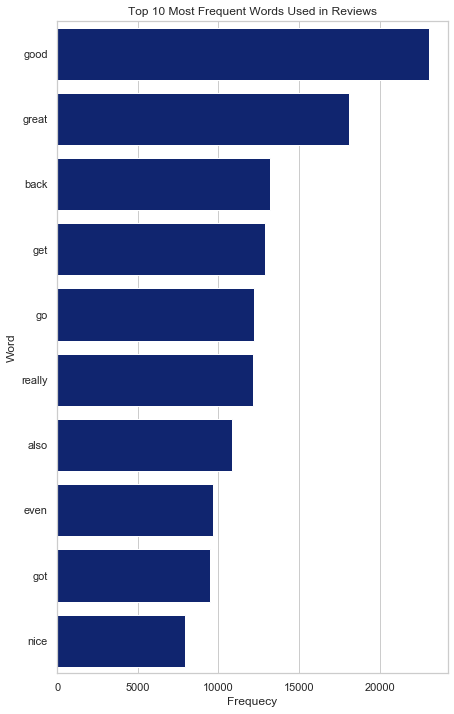

In [99]:
sns.set(style="whitegrid")
sns.set_color_codes("dark")

plt.figure(figsize=(7,12))
sns.barplot(x=most_words[1], y=most_words[0], color='b')
plt.title("Top 10 Most Frequent Words Used in Reviews")
plt.ylabel("Word")
plt.xlabel("Frequecy");

In [22]:
feature_sets = [(review_features(review), label) for (review, label) in review_list]

In [23]:
random.seed(42)
random.shuffle(feature_sets)

In [24]:
training_set = feature_sets[:40000]
testing_set = feature_sets[40000:]

In [25]:
%time NB_classifier = nltk.NaiveBayesClassifier.train(training_set)

Wall time: 1min 45s


In [26]:
%time NB_accuracy = nltk.classify.accuracy(NB_classifier, testing_set)

Wall time: 1min 4s


In [109]:
neg_informative = {
    'unprofessional': 33.4,
    'disgusting': 30.8,
    'inedible': 27.7,
    'worst': 19.2,
    'acknowledged': 18.4,
    'rude': 16.3,
    'tasteless': 15,
    'uncaring': 14.9,
    'depressed': 13.6,
    'terrible': 12.3
}

pos_informative = {
    'exceeded': 13.9,
    'gem': 13.3,
    'heavenly': 9.7,
    'addicting': 9.5,
    'hooked': 8.9,
    'impeccable': 7.8,
    'coolest': 7.7,
    'magnificent': 7.4,
    'focuses': 7.1,
    'wonderfully': 6.7 
}

In [113]:
neg_df = pd.DataFrame(list(neg_informative.items()), columns=['word','ratio'])
pos_df = pd.DataFrame(list(pos_informative.items()), columns=['word','ratio'])

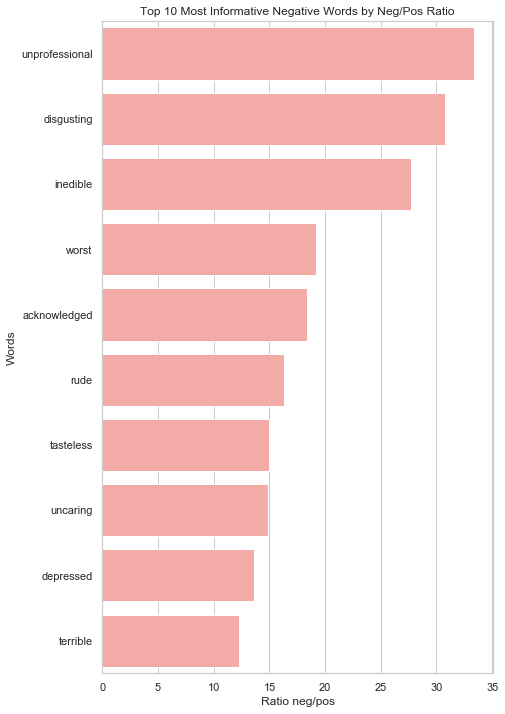

In [124]:
sns.set_color_codes("pastel")

plt.figure(figsize=(7,12))
sns.barplot(x=neg_df['ratio'], y=neg_df['word'], color='r')
plt.title("Top 10 Most Informative Negative Words by Neg/Pos Ratio")
plt.ylabel("Words")
plt.xlabel('Ratio neg/pos');

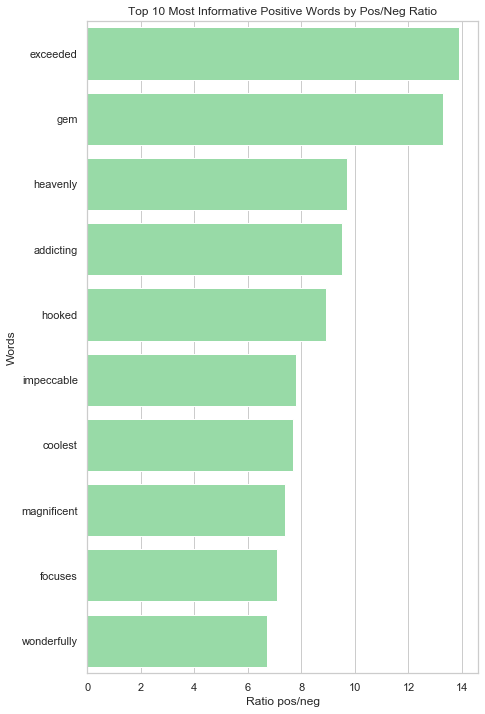

In [125]:
sns.set_color_codes("pastel")

plt.figure(figsize=(7,12))
sns.barplot(x=pos_df['ratio'], y=pos_df['word'], color='g')
plt.title("Top 10 Most Informative Positive Words by Pos/Neg Ratio")
plt.ylabel("Words")
plt.xlabel('Ratio pos/neg');

In [127]:
NB_classifier.show_most_informative_features(10)

Most Informative Features
          unprofessional = True              neg : pos    =     33.4 : 1.0
              disgusting = True              neg : pos    =     30.8 : 1.0
                inedible = True              neg : pos    =     27.7 : 1.0
                   worst = True              neg : pos    =     19.2 : 1.0
            acknowledged = True              neg : pos    =     18.4 : 1.0
                    rude = True              neg : pos    =     16.3 : 1.0
               tasteless = True              neg : pos    =     15.0 : 1.0
                uncaring = True              neg : pos    =     14.9 : 1.0
                exceeded = True              pos : neg    =     13.9 : 1.0
               depressed = True              neg : pos    =     13.6 : 1.0


In [28]:
print(f'Naive Bayes Classifier accuracy: {NB_accuracy}')

Naive Bayes Classifier accuracy: 0.7719


# Try multiple classification models

In [29]:
# create multiple classification models
MultiNB_classifier = SklearnClassifier(MultinomialNB())
BernNB_classifier = SklearnClassifier(BernoulliNB())
LogisticReg_classifier = SklearnClassifier(LogisticRegression(n_jobs=-1))
SGD_classifier = SklearnClassifier(SGDClassifier(n_jobs=-1))
LinearSVC_classifier = SklearnClassifier(LinearSVC(max_iter=10000))

In [30]:
# train all of the models
%time MultiNB_classifier.train(training_set)

Wall time: 1min 17s


<SklearnClassifier(MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))>

In [31]:
%time BernNB_classifier.train(training_set)

Wall time: 1min 14s


<SklearnClassifier(BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True))>

In [32]:
%time LogisticReg_classifier.train(training_set)

C:\Users\andre\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\andre\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


Wall time: 2min 29s


<SklearnClassifier(LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=-1, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False))>

In [33]:
%time SGD_classifier.train(training_set)

Wall time: 1min 22s


<SklearnClassifier(SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=-1, penalty='l2',
              power_t=0.5, random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False))>

In [34]:
%time LinearSVC_classifier.train(training_set)

Wall time: 10min 51s


<SklearnClassifier(LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=10000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0))>

In [35]:
# accuracy for all models
MultiNB_accuracy = nltk.classify.accuracy(MultiNB_classifier, testing_set)
BernNB_accuracy = nltk.classify.accuracy(BernNB_classifier, testing_set)
LogisticReg_accuracy = nltk.classify.accuracy(LogisticReg_classifier, testing_set)
SGD_accuracy = nltk.classify.accuracy(SGD_classifier, testing_set)
LinearSVC_accuracy = nltk.classify.accuracy(LinearSVC_classifier, testing_set)

In [36]:
print(f'Multinomial Naivey Bayes Classifier accuracy: {MultiNB_accuracy}')
print(f'Bernoulli Naivey Bayes Classifier accuracy: {BernNB_accuracy}')
print(f'Logistic Regression Classifier accuracy: {LogisticReg_accuracy}')
print(f'SGDClassifier accuracy: {SGD_accuracy}')
print(f'Linear Support Vector Classifier accuracy: {LinearSVC_accuracy}')

Multinomial Naivey Bayes Classifier accuracy: 0.843
Bernoulli Naivey Bayes Classifier accuracy: 0.7701
Logistic Regression Classifier accuracy: 0.8645
SGDClassifier accuracy: 0.8639
Linear Support Vector Classifier accuracy: 0.8564
